In [3]:
%matplotlib inline
import cv2
import numpy as np
from scipy.signal import convolve2d
from scipy.ndimage.filters import correlate 
import matplotlib.pyplot as plt
import matplotlib.image as pltimg 
from scipy.ndimage.filters import gaussian_laplace
from scipy.ndimage.filters import maximum_filter
from skimage.feature import peak_local_max
from skimage.transform import resize
import math

In [4]:
def load_image(path):
    '''
    :param path: path to load image
    :return: grayscaled and float image
    '''
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    # transmit the image to float
    img = img.astype(np.float64)/255.0

    print(img.shape)
    return img

In [5]:
def normalize(img):
    ''' Function to normalize an input array to 0-1 '''
    img_min = img.min()
    img_max = img.max()
    return (img - img_min) / (img_max - img_min)

def generate_laplacian_filter(size, sigma):
    return gaussian_laplace(np.zeros((size,size)),sigma=sigma)

In [6]:
def show_all_circles(image, cx, cy, rad, color='r'):
    """
    image: numpy array, representing the grayscsale image
    cx, cy: numpy arrays or lists, centers of the detected blobs
    rad: numpy array or list, radius of the detected blobs
    """
    import matplotlib.pyplot as plt
    from matplotlib.patches import Circle

    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    ax.imshow(image, cmap='gray')
    
    for i in range(len(cx)):
        circ = Circle((cx[i], cy[i]), rad[i], color=color, fill=False)
        ax.add_patch(circ)

    plt.title('%i circles' % len(cx))
    plt.show()

In [15]:

def blob_detector(img, sigma, k, levels, threshold, method):
    sigma = float(sigma)
    initial_sigma = sigma
    height, width = img.shape
    
    # Increase the filter size method
    if method == 'upscale':
        print("using upscale method!")
        img_scale_space = np.zeros((height, width, levels), dtype=np.float64)
        for i in range(levels):
            img_scale_space[:, :, i] = np.power(gaussian_laplace(img, sigma=sigma) * sigma**2, 2)
            sigma = sigma * k
            
    elif method == "downsample":
        print("using downsample method!")
        # TODO: add to report: filter size shall be odd
        img_scale_space = np.zeros((height, width, levels), dtype=np.float64)
        for i in range(levels):
            new_shape = (int(height * (1.0/np.power(k, i))),int(width* (1.0/np.power(k, i))))
            img_small = resize(img, new_shape)
            # print("at level %d, img_small size =%s" % (i, str(img_small.shape)))
            # temp = np.absolute(gaussian_laplace(img_copyed, sigma=sigma) * sigma**2)
            img_tmp = np.power(gaussian_laplace(img_small, sigma=sigma, truncate=0.8), 2)
            #use int to indicate new size
            img_scale_space[:, :, i] = resize(img_tmp, img.shape) 
            #use fraction of current size
            
    print("scaled image space generated!")
    
    
    '''
        Non maximum supression:
            1.first: maximum filter the image
            2.check if a position is largest
            3.filtered out non_maxmum position in img
    '''
    max_filterd_space = np.zeros(img_scale_space.shape, dtype=np.float64)

    for i in range(levels):
        max_filterd_space[:, :, i] = maximum_filter(img_scale_space[:, :, i], size=(3, 3))
       
    maxima_space = np.zeros((height, width), dtype=np.float64)
    # along with level max value
    maxima_space = np.max(max_filterd_space, axis=2)

    survive_space = np.zeros(img_scale_space.shape, dtype=np.float64)
    # locating survive pos

    for i in range(levels):
        boolean_space = (maxima_space == img_scale_space[:, :, i])
        survive_space[:, :, i] = boolean_space * img
    
    print("begin drawing circles!")

    cx = []
    cy = []
    radius = []
    for i in range(levels):
        location = np.argwhere(survive_space[:, :, i] >= threshold)
        # in higher scale have larger radius
        rad = np.sqrt(2) * initial_sigma * np.power(k, i)
        cx = cx + [x[0] for x in location]
        cy = cy + [x[1] for x in location]
        radius = radius + [rad]*len(location)
        # print("At level %d, possible  %d circles, actual %d circles" % (np.count_nonzero(survive_space[:, :, i]),i, len(location)))
        
    # with open("coor.txt","w") as fp:
    #     pos = zip(cx,cy,radius)
    #     fp.write(str([x for x in pos]))
    
    print("circle numebrs %d" %(len(cx)))
    
    # !!! Attention, cx and cy are reversed
    show_all_circles(img, cy, cx, radius)


In [16]:

BUTTERFLY = "data\\part2\\butterfly.jpg" 
EINSTEIN = "data\\part2\\einstein.jpg"
FISHES = "data\\part2\\fishes.jpg"
SUNFLOWERS =  "data\\part2\\sunflowers.jpg"

(356, 493)
using upscale method!


scaled image space generated!
begin drawing circles!


circle numebrs 1006


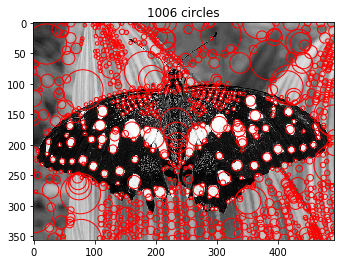

In [17]:
# upscaling parameters
'''
k           increasing factor K
levels      number of iterations
'''
threshold = 0.25
k = 1.25   
levels = 12                   
sigma = 2

img = load_image(BUTTERFLY)
blob_detector(img, sigma, k, levels, threshold, method = 'upscale')

using downsample method!


C:\Users\liuzhe\mp0\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\liuzhe\mp0\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


scaled image space generated!
begin drawing circles!


circle numebrs 1138


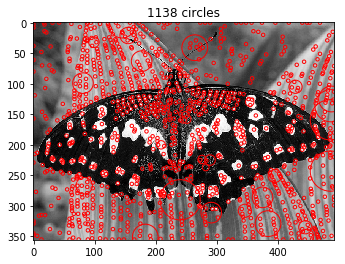

In [18]:
# img = load_image(EINSTEIN)
threshold = 0.25
k = 1.25
levels = 12                   
sigma = 2
blob_detector(img, sigma, k, levels, threshold, method = 'downsample')

In [42]:
#define DOG
def generate_gaussian_kernel(rows, cols, sigma, highPass=True):
    '''
    :param rows: rows of gaussian kernel
    :param cols: cols of gaussian kernel
    :param sigma: sigma
    :param highPass: if this kernel is in highpass mode
    :return: 
    '''
    center_row = int(rows/2) + 1 if rows % 2 == 1 else int(rows/2)
    center_col = int(cols/2) + 1 if cols % 2 == 1 else int(cols/2)
    def gaussian_at_pos(i,j):  
        coefficient = np.exp(-1.0 * ((i - center_row)**2 + (j - center_col)**2) / (2 * sigma**2))
        return 1 - coefficient if highPass else coefficient
    
    return np.array([[gaussian_at_pos(i, j) for j in range(cols)] for i in range(rows)])



def dog_method(img, threshold, k, levels, octave, sigma):
    sigma = float(sigma)
    initial_sigma = sigma
    height, width = img.shape

    for oct in range(0,octave*2+1,2):
        print("current oct")
        sigma = initial_sigma * np.power(k, 2*oct)
        if oct == 0:
            new_shape = img.shape
        else:
            new_shape = (int(height/oct), int(width/oct))
        cur_octave = resize(img, new_shape)
        img_scale_space_tmp = np.zeros((*new_shape, levels))
        
        for i in range(levels):
            img_scale_space_tmp[:, :, i] = (correlate(cur_octave, 
                                                      generate_gaussian_kernel(3, 3, sigma)) ** 2)
            if oct != 0:
                img_scale_space_tmp[:, :, i] *= (np.power(sigma, 2))
            sigma *= k
        
        # img_scale_space height*width*levels-1
        img_scale_space = np.zeros((*new_shape, levels-1))
        for i in range(1, levels):
            img_scale_space[:, :, i-1] = img_scale_space_tmp[:, :, i] - img_scale_space_tmp[:, :, i-1]
        if oct == 0:
            scale_space_1 = img_scale_space
        if oct == 2:
            scale_space_2 = img_scale_space
        if oct == 4:
            scale_space_3 = img_scale_space
        
       
    
    # Scale_space resize to oringinal image
    for i in range(scale_space_2.shape[2]):
        scale_space_2[:,:,i] = resize(  scale_space_2[:,:,i], img.shape)
        scale_space_3[:,:,i] = resize(  scale_space_3[:,:,i], img.shape)
    

    # diff space size: height * width * octave * octave
    diff_space = np.stack((scale_space_1,scale_space_2,scale_space_3), axis=2)
    
    for i in range(diff_space.shape[2]):
        maxmum_diff_space = maximum_filter(diff_space[:, :, i], size=(3,3))
        tmp = diff_space[:, :, i] * (maxmum_diff_space == diff_space[:, :, i])
        tmp[tmp < threshold] = 0
        diff_space[:, :, i] = tmp
        
        
    # survival space: same as diff_space size
    # generate survival matrix
    # TODO: test if dimenstion fulfill
    lm = maximum_filter(diff_space, size = (3,3,3))
    mask = (img == lm)
    survival_space = diff_space * mask
    
    
  
    print("begin drawing circles!")

    cx = []
    cy = []
    radius = []
    for i in range(octave):
        location = np.argwhere(survive_space[:, :, i] > 0)
        rad = initial_sigma * np.power(k, i)
        if i < 3:
            rad *= np.power(np.sqrt(2), i) 
        elif i < 6:
            rad *=  np.power(np.sqrt(2), i-3) * np.sqrt(2)
        else:
            rad *= np.power(np.sqrt(2), i-6) * 2
        cx = cx + [x[0] for x in location]
        cy = cy + [x[1] for x in location]
        radius = radius + [rad]*len(location)
        # print("At level %d, possible  %d circles, actual %d circles" % (np.count_nonzero(survive_space[:, :, i]),i, len(location)))
        
    # with open("coor.txt","w") as fp:
    #     pos = zip(cx,cy,radius)
    #     fp.write(str([x for x in pos]))
    
    print("circle numebrs %d" %(len(cx)))
    
    # !!! Attention, cx and cy are reversed
    show_all_circles(img, cy, cx, radius)

In [43]:
# Extra credit:DOG method
threshold = 0.9
k = np.sqrt(2)
levels = 4
octave = 3
initial_sigma = 2
sigma = 2
dog_method(img,threshold,k,levels,octave,sigma)

current oct
current oct


C:\Users\liuzhe\mp0\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\liuzhe\mp0\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


ValueError: all the input array dimensions except for the concatenation axis must match exactly